# Example Evaluation

In [1]:
%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
from llm import plot_utils as pu
from llm.datasets import datasets

In [2]:
dataset = 'sst2'
model = 'LLaMa-2-70B'
class_names = datasets[dataset].class_name_variants
class_names

{'default': ['negative', 'positive'],
 'flip': ['positive', 'negative'],
 'rating_1': ['bad', 'good'],
 'rating_2': ['good', 'bad'],
 'options_1': ['A', 'B'],
 'options_2': ['B', 'A'],
 'colors_1': ['green', 'blue'],
 'colors_2': ['blue', 'green'],
 'sea_chair_1': ['sea', 'chair'],
 'sea_chair_2': ['chair', 'sea']}

## Default and Randomized Labels

In [3]:
runs = {
    'Default': '1j9wmm0u',
    'Random': '6fesafwv',
}
experiments = list(runs.keys())
results = {name: pu.wandb_restore(slurmid) for name, slurmid in runs.items()}

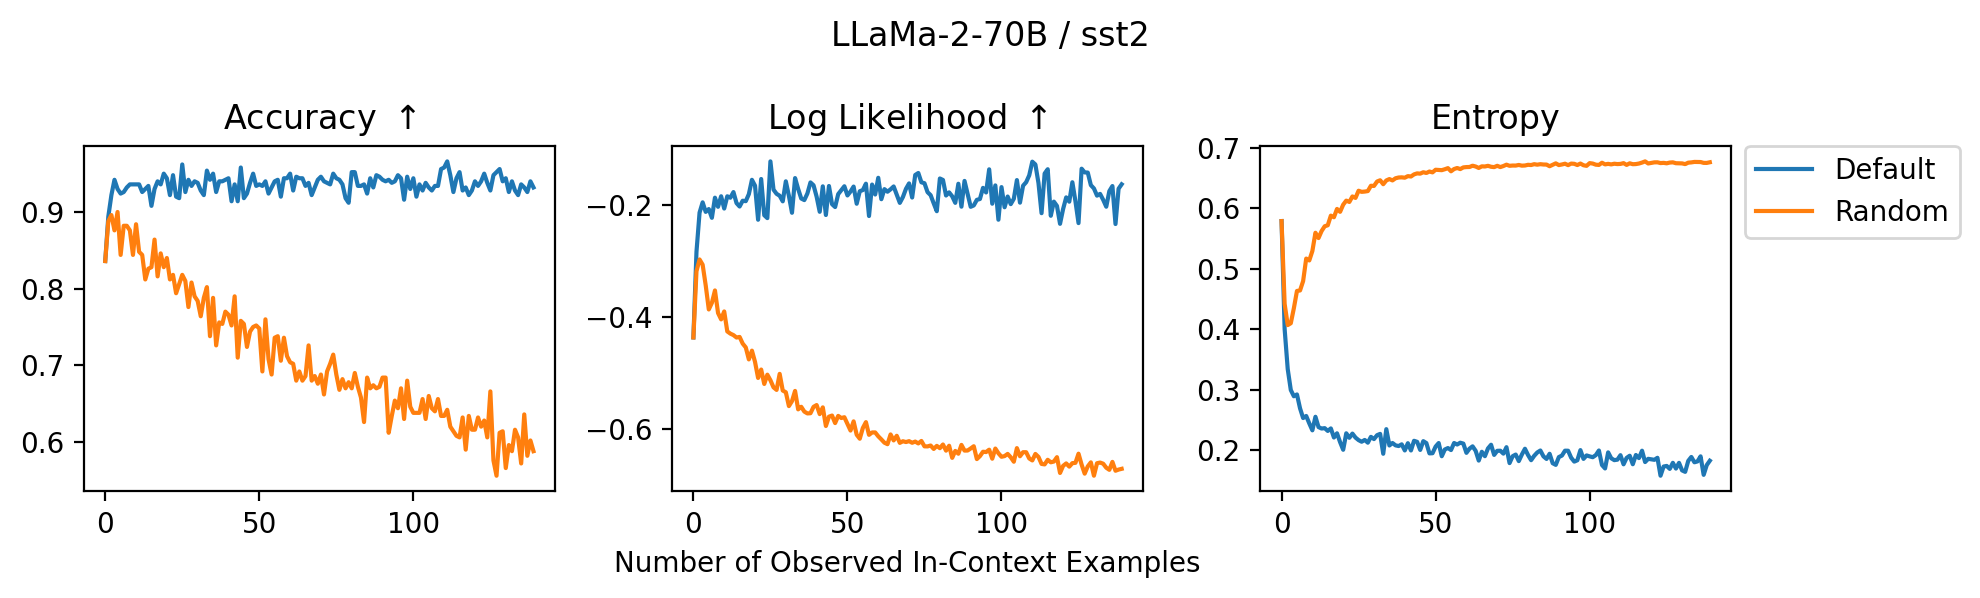

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3), dpi=200, sharex='row')
fig.suptitle(f'{model} / {dataset}')

smooth_n = 1
for experiment in experiments:
    for k, (ax, metric) in enumerate(zip(axes, pu.metrics_dict)):
        ax.set_title(pu.metrics_dict[metric])
        sub_results = {model: results[experiment]}
        all_classes = results[experiment]['setup']['all_classes']
        label_setup = 'default'
        args = [sub_results, all_classes, class_names]
        values = pu.get_values(*args, model=model, label_setup=label_setup, value=metric, smooth_n=1)
        ax.plot(values, label=experiment)

axes[-1].legend(loc='upper left', bbox_to_anchor=(1, 1.04))
axes[1].set_xlabel(r'Number of Observed In-Context Examples')
plt.tight_layout()

## Replacement Labels

In [5]:
replacement_results = pu.wandb_restore('t5sex6d2')

In [6]:
label_setups = [i for i in list(class_names.keys())]
label_setups

['default',
 'flip',
 'rating_1',
 'rating_2',
 'options_1',
 'options_2',
 'colors_1',
 'colors_2',
 'sea_chair_1',
 'sea_chair_2']

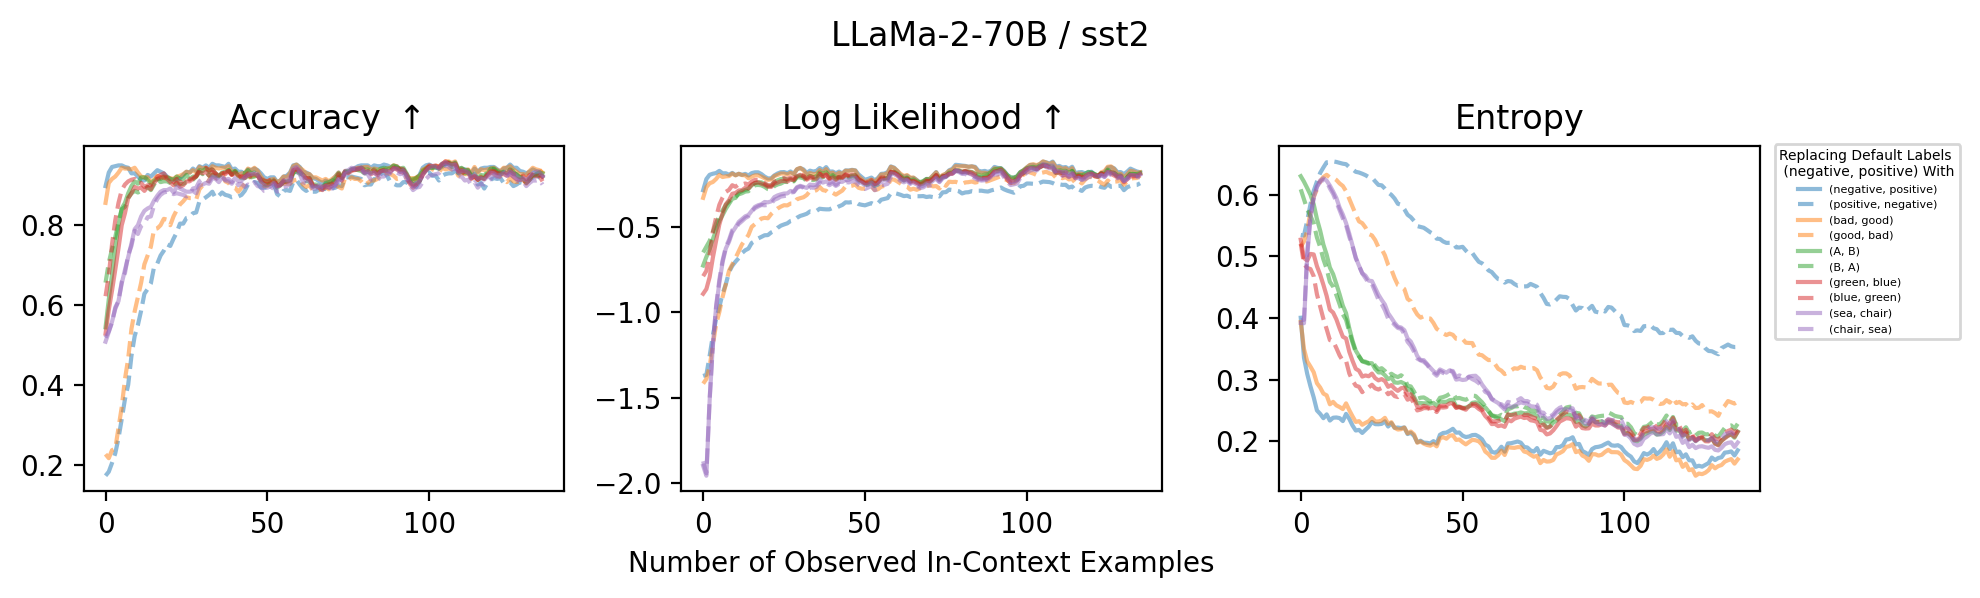

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3), dpi=200, sharex='row')
fig.suptitle(f'{model} / {dataset}')

sub_results = {model: replacement_results}
all_classes = replacement_results['setup']['all_classes']
args = [sub_results, all_classes, class_names]

for ax, metric in zip(axes, pu.metrics_dict):
    ax.set_title(pu.metrics_dict[metric])
    for k, label_setup in enumerate(label_setups):
        values = pu.get_values(*args, model=model, label_setup=label_setup, value=metric)
        label = '(' + ', '.join(class_names[label_setup]) + ')'
        ax.plot(values, label=label, c=f'C{k//2}', ls='-' if k % 2 == 0 else '--', alpha=0.5)

axes[-1].legend(title='Replacing Default Labels \n (negative, positive) With', loc='upper left', bbox_to_anchor=(1.02, 1.02), fontsize=4, title_fontsize=5)
axes[1].set_xlabel(r'Number of Observed In-Context Examples')
plt.tight_layout()

# Dynamic Label Flip

In [8]:
runs = {
    'Halfway': 'uimh6lq7',
    'Alternating': 'emblusyc',
}
experiments = list(runs.keys())
results = {name: pu.wandb_restore(slurmid) for name, slurmid in runs.items()}

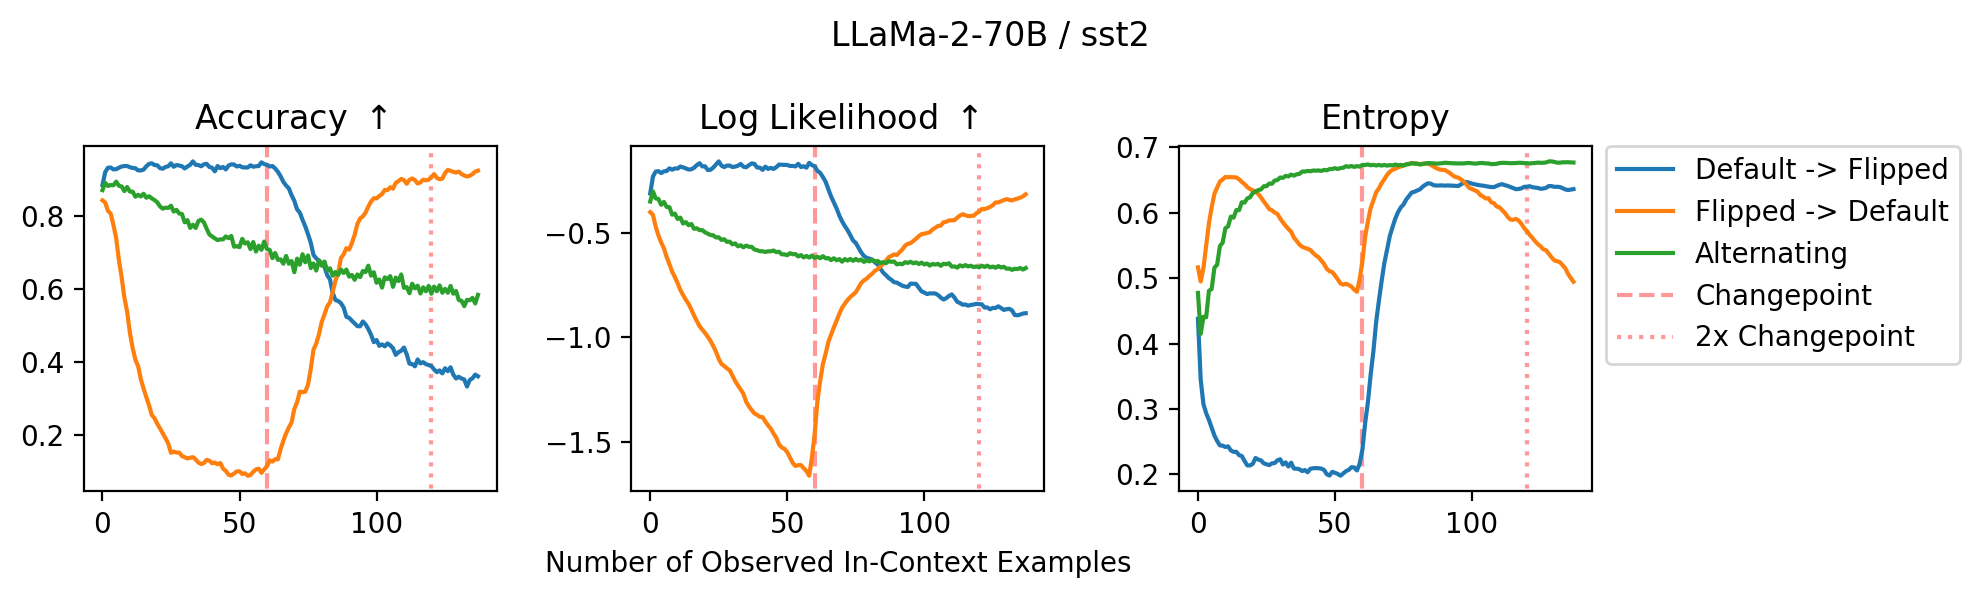

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3), dpi=200, sharex='row')
fig.suptitle(f'{model} / {dataset}')

smooth_n = 1
for experiment in experiments:
    for k, (ax, metric) in enumerate(zip(axes, pu.metrics_dict)):
        ax.set_title(pu.metrics_dict[metric])
        sub_results = {model: results[experiment]}
        all_classes = results[experiment]['setup']['all_classes']

        if experiment == 'Halfway':
            label_setups = ['default', 'flip']
            labels = ['Default -> Flipped', 'Flipped -> Default']
        else:
            label_setups = ['default']
            labels = ['Alternating']

        for label, label_setup in zip(labels, label_setups):
            args = [sub_results, all_classes, class_names]
            values = pu.get_values(*args, model=model, label_setup=label_setup, choose_logits='default', value=metric, smooth_n=3)
            ax.plot(values, label=label)

for ax in axes:
    lims = ax.get_ylim()
    ax.plot([60, 60], [-10, 10], c='r', alpha=0.4, zorder=-10, ls='--', label='Changepoint')
    ax.plot([120, 120], [-10, 10], c='r', alpha=0.4, zorder=-10, ls=':', label='2x Changepoint')
    ax.set_ylim(*lims)

axes[-1].legend(loc='upper left', bbox_to_anchor=(1, 1.04))
axes[1].set_xlabel(r'Number of Observed In-Context Examples')
plt.tight_layout()